In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

summary_features = pd.read_csv('/content/drive/My Drive/participant_summary.csv')
#summary_features = pd.read_csv('/content/drive/My Drive/full_participant_summary.csv')

print(summary_features.shape)

(275, 1000)


In [ ]:
new_names = []
for i in range(1, 50):  # f1 to f49
    for stat in ['mean', 'std', 'min', 'max']:
        new_names.append(f'OpenFace_f{i}_{stat}')

# Apply renaming to your dataframe
column_indices_to_rename = range(802, 998)  # Inclusive of 802 to 997
summary_features.columns.values[list(column_indices_to_rename)] = new_names

In [ ]:
summary_features = summary_features.loc[:, (summary_features != 0).any(axis=0)]

In [ ]:
summary_features.shape

(275, 782)

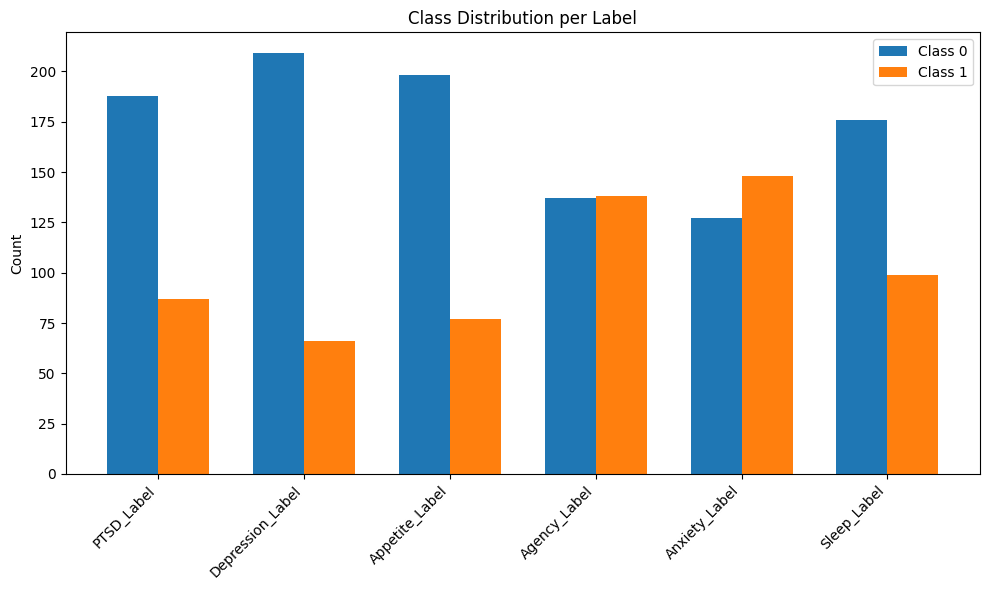

In [ ]:
import matplotlib.pyplot as plt

# Load your label CSV
df = pd.read_csv('/content/drive/My Drive/GroundTruth Table.csv')

# Define labels
labels = ['PTSD_Label',	'Depression_Label',	'Appetite_Label',	'Agency_Label',	'Anxiety_Label',	'Sleep_Label']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(labels))
zeros = [df[label].value_counts().get(0, 0) for label in labels]
ones = [df[label].value_counts().get(1, 0) for label in labels]

bar_width = 0.35
ax.bar([i - bar_width/2 for i in x], zeros, width=bar_width, label='Class 0')
ax.bar([i + bar_width/2 for i in x], ones, width=bar_width, label='Class 1')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Class Distribution per Label')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Separate features (summary_features) and the identified labels
X = summary_features
y = df[labels[0]] #i =0, 1, 2, 3, 4, 5 for diffrent targets
y_all_labels = df[labels[:]] #i =0, 1, 2, 3, 4, 5 for diffrent targets

# Initialize StratifiedKFold with 5 splits
n_splits = 5  # Set to 5 for 5 iterations/folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
y.shape

(275,)

In [ ]:
X.shape

(275, 782)

In [ ]:
X = summary_features.copy()

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [ ]:
discrete_features

,0
participant_id,True
eGeMAPS_f0_mean,False
eGeMAPS_f0_std,False
eGeMAPS_f0_max,False
eGeMAPS_f1_mean,False
...,...
OpenFace_f49_mean,False
OpenFace_f49_std,False
OpenFace_f49_max,False
0.0.42_mean,False


In [ ]:
X.shape

(275, 782)

In [ ]:
X.head()

,participant_id,eGeMAPS_f0_mean,eGeMAPS_f0_std,eGeMAPS_f0_max,eGeMAPS_f1_mean,eGeMAPS_f1_std,eGeMAPS_f1_max,eGeMAPS_f2_mean,eGeMAPS_f2_std,eGeMAPS_f2_max,...,OpenFace_f47_std,OpenFace_f47_max,OpenFace_f48_mean,OpenFace_f48_std,OpenFace_f48_max,OpenFace_f49_mean,OpenFace_f49_std,OpenFace_f49_max,0.0.42_mean,0.0.42_std
0,300,324.2,187.220258,648.4,0.339651,0.412770,1.633468,0.309486,0.527131,2.008600,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,301,411.9,237.853877,823.8,0.417114,0.383984,1.462398,0.508682,0.565141,1.963788,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,302,378.7,218.685848,757.4,0.431654,0.399046,1.414973,0.008801,0.083450,1.041393,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,303,492.0,284.099633,984.0,0.688838,0.391137,1.544068,1.028125,0.639955,2.037427,...,0.0,0.0,0.00323,0.049681,0.778151,0.0,0.0,0.0,0.0,0.0
4,304,393.7,227.346102,787.4,0.594773,0.377326,1.477121,0.658804,0.659056,1.977724,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
y.shape

(275,)

In [ ]:
from sklearn.feature_selection import mutual_info_classif


In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)

    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

,MI Scores
participant_id,0.624098
eGeMAPS_f0_mean,0.037315
eGeMAPS_f0_std,0.037110
eGeMAPS_f0_max,0.038103
eGeMAPS_f1_mean,0.000000
...,...
OpenFace_f49_mean,0.018414
OpenFace_f49_std,0.000000
OpenFace_f49_max,0.045532
0.0.42_mean,0.012231


In [ ]:
# Filter non-zero scores
filtered_scores = mi_scores[mi_scores > 0]

# Filter DataFrame to match filtered scores
filtered_X = X[filtered_scores.index]

In [ ]:
# Step 1: Compute correlation matrix
corr_matrix = filtered_X.corr().abs()

# Step 2: Mark pairs with correlation > 0.8
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        if corr_matrix.loc[col1, col2] > 0.8:
            # Compare scores, drop the one with lower score
            if filtered_scores[col1] >= filtered_scores[col2]:
                to_drop.add(col2)
            else:
                to_drop.add(col1)

# Step 3: Drop columns
final_X = filtered_X.drop(columns=to_drop)
final_scores = filtered_scores.drop(labels=to_drop)

# Printing final_X after all filters applied
print(final_X.shape)
print(final_X.columns.tolist())

(275, 281)
['participant_id', 'eGeMAPS_f2_max', 'eGeMAPS_f3_std', 'eGeMAPS_f4_max', 'eGeMAPS_f5_max', 'eGeMAPS_f6_mean', 'eGeMAPS_f6_max', 'eGeMAPS_f9_mean', 'eGeMAPS_f10_std', 'eGeMAPS_f10_min', 'eGeMAPS_f12_std', 'eGeMAPS_f14_max', 'eGeMAPS_f16_mean', 'eGeMAPS_f16_std', 'eGeMAPS_f17_mean', 'eGeMAPS_f17_min', 'eGeMAPS_f20_max', 'eGeMAPS_f21_mean', 'eGeMAPS_f22_max', 'eGeMAPS_f23_std', 'eGeMAPS_f24_std', 'eGeMAPS_f25_mean', 'eGeMAPS_f26_std', 'eGeMAPS_f27_mean', 'eGeMAPS_f28_max', 'eGeMAPS_f29_mean', 'eGeMAPS_f30_std', 'eGeMAPS_f31_mean', 'eGeMAPS_f34_mean', 'eGeMAPS_f35_max', 'eGeMAPS_f36_std', 'eGeMAPS_f37_std', 'eGeMAPS_f38_std', 'eGeMAPS_f39_std', 'eGeMAPS_f39_max', 'eGeMAPS_f40_max', 'eGeMAPS_f41_min', 'eGeMAPS_f42_mean', 'eGeMAPS_f42_max', 'eGeMAPS_f43_max', 'eGeMAPS_f44_std', 'eGeMAPS_f45_std', 'eGeMAPS_f46_max', 'eGeMAPS_f47_max', 'eGeMAPS_f49_mean', 'eGeMAPS_f50_std', 'eGeMAPS_f51_std', 'eGeMAPS_f52_max', 'eGeMAPS_f53_mean', 'eGeMAPS_f53_max', 'eGeMAPS_f55_mean', 'eGeMAPS_f55_

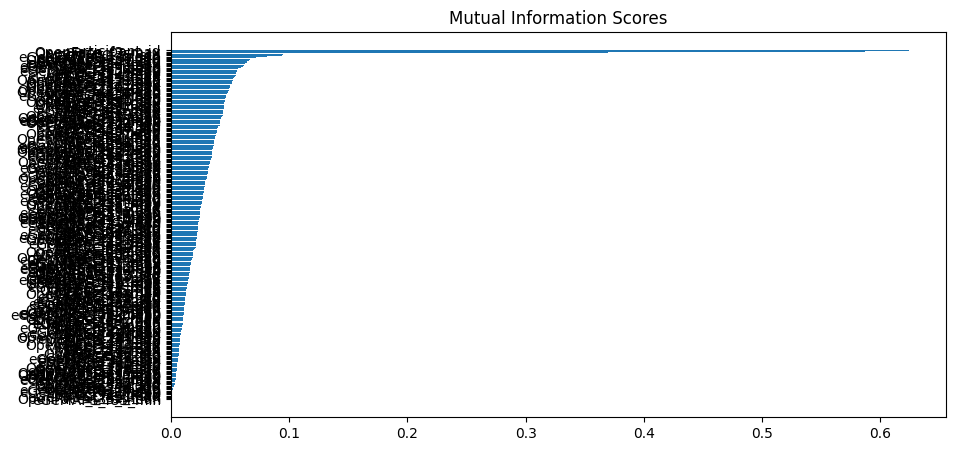

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(10, 5))
plot_mi_scores(final_scores)

In [ ]:
# Find first index that contains 'OpenFace'
first_match_pos = next(i for i, idx in enumerate(final_scores.index) if "OpenFace" in idx)

# Split the series
before_openface = final_scores.iloc[:first_match_pos]
from_openface_onward = final_scores.iloc[first_match_pos:]


In [ ]:
top_20_percent = int(len(before_openface) * 0.1)
print(top_20_percent)

# Sort the scores in descending order
top_features = before_openface.sort_values(ascending=False).head(top_20_percent)
top_features_list_before = top_features.index.tolist()

top_20_percent = int(len(from_openface_onward) * 0.4)
print(top_20_percent)

# Sort the scores in descending order
top_features = from_openface_onward.sort_values(ascending=False).head(top_20_percent)
top_features_list_after = top_features.index.tolist()

top_features_list = top_features_list_before + top_features_list_after
print(len(top_features_list_before))
print(len(top_features_list_after))

# Print the column names
print("Top 20% feature names:")
print(top_features_list)

21
24
21
24
Top 20% feature names:
['participant_id', 'MFCC_f5_std', 'MFCC_f51_mean', 'eGeMAPS_f16_mean', 'eGeMAPS_f38_std', 'eGeMAPS_f51_std', 'eGeMAPS_f77_std', 'eGeMAPS_f98_max', 'eGeMAPS_f72_mean', 'MFCC_f2_std', 'eGeMAPS_f53_mean', 'MFCC_f38_std', 'eGeMAPS_f25_mean', 'MFCC_f30_max', 'MFCC_f17_max', 'MFCC_f88_mean', 'eGeMAPS_f14_max', 'MFCC_f34_max', 'MFCC_f11_mean', 'eGeMAPS_f47_max', 'MFCC_f61_std', 'OpenFace_f3_max', 'OpenFace_f2_max', 'OpenFace_f5_mean', 'OpenFace_f46_max', 'OpenFace_f18_mean', 'OpenFace_f3_std', 'OpenFace_f2_mean', 'OpenFace_f13_max', 'OpenFace_f30_max', 'OpenFace_f23_mean', 'OpenFace_f48_mean', 'OpenFace_f5_std', 'OpenFace_f4_min', 'OpenFace_f10_std', 'OpenFace_f49_max', 'OpenFace_f31_std', 'OpenFace_f34_max', 'OpenFace_f43_mean', 'OpenFace_f28_max', 'OpenFace_f26_max', 'OpenFace_f32_max', 'OpenFace_f28_mean', 'OpenFace_f19_mean', 'OpenFace_f29_mean']


In [ ]:
len(top_features_list_after)

24

In [ ]:
# top_20_percent = int(len(final_scores) * 0.2)

# # Sort the scores in descending order
# top_features = final_scores.sort_values(ascending=False).head(top_20_percent)
# top_features_list = top_features.index.tolist()
# # Print the column names
# print("Top 20% feature names:")
# print(top_features.index.tolist())

In [ ]:
import re

extracted_features = []

for feature in top_features_list:
    match = re.match(r'^(MFCC|eGeMAPS|FAU)_f(\d+)_((?:mean)|(?:std)|(?:min)|(?:max))$', feature)
    if match:
        category, number, _ = match.groups()
        number = int(number)
        if category == "MFCC":
            mapped = f"feature_{number-1}"
        elif category == "eGeMAPS":
            mapped = f"feature_{number + 100-1}"
        elif category == "FAU":
            mapped = f"feature_{number + 200-1}"
        extracted_features.append(mapped)

print("Extracted feature names:")
print(extracted_features)

Extracted feature names:
['feature_4', 'feature_50', 'feature_115', 'feature_137', 'feature_150', 'feature_176', 'feature_197', 'feature_171', 'feature_1', 'feature_152', 'feature_37', 'feature_124', 'feature_29', 'feature_16', 'feature_87', 'feature_113', 'feature_33', 'feature_10', 'feature_146', 'feature_60']


In [ ]:


# Dictionaries to store results and accumulated true labels and predictions
model_accuracies = {
    'Logistic Regression': [],
    'MLP Classifier': [],
    'XGBoost Classifier': [],
    'SVM Classifier': [],
    'Ridge Classifier': []
}

all_y_true = {
    'Logistic Regression': [],
    'MLP Classifier': [],
    'XGBoost Classifier': [],
    'SVM Classifier': [],
    'Ridge Classifier': []
}

all_y_pred = {
    'Logistic Regression': [],
    'MLP Classifier': [],
    'XGBoost Classifier': [],
    'SVM Classifier': [],
    'Ridge Classifier': []
}

# Iterate through folds
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"--- Fold {fold+1}/{n_splits} ---")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Append true labels for this fold to the dictionary
    for model_name in all_y_true.keys():
        all_y_true[model_name].extend(y_test)

    # --- Logistic Regression ---
    print("Training Logistic Regression...")
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)
    y_pred_log_reg = log_reg.predict(X_test)
    accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
    model_accuracies['Logistic Regression'].append(accuracy_log_reg)
    all_y_pred['Logistic Regression'].extend(y_pred_log_reg)

    # --- MLP Classifier ---
    print("Training MLP Classifier...")
    model_mlp = Sequential([
        Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(1, activation='softmax')
    ])
    model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_mlp.fit(X_train, y_train.values, epochs=10, batch_size=32, verbose=0)
    loss_mlp, accuracy_mlp = model_mlp.evaluate(X_test, y_test.values, verbose=0)
    model_accuracies['MLP Classifier'].append(accuracy_mlp)
    y_pred_mlp_prob = model_mlp.predict(X_test)
    y_pred_mlp = (y_pred_mlp_prob > 0.5).astype(int)
    all_y_pred['MLP Classifier'].extend(y_pred_mlp.flatten())

    # --- XGBoost Classifier ---
    print("Training XGBoost Classifier...")
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    model_accuracies['XGBoost Classifier'].append(accuracy_xgb)
    all_y_pred['XGBoost Classifier'].extend(y_pred_xgb)

    # --- Support Vector Machine (SVM) Classifier ---
    print("Training SVM Classifier...")
    svm_model = SVC(kernel='rbf', probability=True, random_state=42)
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    model_accuracies['SVM Classifier'].append(accuracy_svm)
    all_y_pred['SVM Classifier'].extend(y_pred_svm)

    # --- Ridge Classifier ---
    print("Training Ridge Classifier...")
    ridge_classifier_model = RidgeClassifier(random_state=42)
    ridge_classifier_model.fit(X_train, y_train)
    y_pred_ridge_classifier = ridge_classifier_model.predict(X_test)
    accuracy_ridge_classifier = accuracy_score(y_test, y_pred_ridge_classifier)
    model_accuracies['Ridge Classifier'].append(accuracy_ridge_classifier)
    all_y_pred['Ridge Classifier'].extend(y_pred_ridge_classifier)


# Print average results
print("\n--- Average Cross-Validation Results ---")
for model_name, accuracies in model_accuracies.items():
    avg_accuracy = np.mean(accuracies)
    print(f"{model_name}: Average Accuracy = {avg_accuracy:.4f}")

# Print classification reports at the end
print("\n--- Classification Reports (Aggregated Across Folds) ---")
for model_name in all_y_true.keys():
    print(f"\n--- {model_name} ---")
    true_labels = np.array(all_y_true[model_name])
    predicted_labels = np.array(all_y_pred[model_name])
    print(classification_report(true_labels, predicted_labels))

--- Fold 1/5 ---
Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis h

Training MLP Classifier...


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Training XGBoost Classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training SVM Classifier...
Training Ridge Classifier...
--- Fold 2/5 ---
Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis h

Training MLP Classifier...


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Training XGBoost Classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training SVM Classifier...
Training Ridge Classifier...
--- Fold 3/5 ---
Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis h

Training MLP Classifier...


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Training XGBoost Classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training SVM Classifier...
Training Ridge Classifier...
--- Fold 4/5 ---
Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training MLP Classifier...


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Training XGBoost Classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training SVM Classifier...
Training Ridge Classifier...
--- Fold 5/5 ---
Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training MLP Classifier...


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Training XGBoost Classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training SVM Classifier...
Training Ridge Classifier...

--- Average Cross-Validation Results ---
Logistic Regression: Average Accuracy = 0.6764
MLP Classifier: Average Accuracy = 0.3164
XGBoost Classifier: Average Accuracy = 0.6873
SVM Classifier: Average Accuracy = 0.6836
Ridge Classifier: Average Accuracy = 0.6364

--- Classification Reports (Aggregated Across Folds) ---

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       188
           1       0.49      0.44      0.46        87

    accuracy                           0.68       275
   macro avg       0.62      0.61      0.61       275
weighted avg       0.67      0.68      0.67       275


--- MLP Classifier ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       188
           1       0.32      1.00      0.48        87

    accuracy                           0.32       275
   macro avg       0.16  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

# Model for Temporal Features (CNN+BILSTM)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, BatchNormalization, GlobalMaxPooling1D, Dropout
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
#appending SBERT embeddings to selected features
for i in range(249,633,1):
  extracted_features.append("feature_"+str(i))
print(extracted_features)
print(len(extracted_features))

['feature_4', 'feature_50', 'feature_115', 'feature_137', 'feature_150', 'feature_176', 'feature_197', 'feature_171', 'feature_1', 'feature_152', 'feature_37', 'feature_124', 'feature_29', 'feature_16', 'feature_87', 'feature_113', 'feature_33', 'feature_10', 'feature_146', 'feature_60', 'feature_249', 'feature_250', 'feature_251', 'feature_252', 'feature_253', 'feature_254', 'feature_255', 'feature_256', 'feature_257', 'feature_258', 'feature_259', 'feature_260', 'feature_261', 'feature_262', 'feature_263', 'feature_264', 'feature_265', 'feature_266', 'feature_267', 'feature_268', 'feature_269', 'feature_270', 'feature_271', 'feature_272', 'feature_273', 'feature_274', 'feature_275', 'feature_276', 'feature_277', 'feature_278', 'feature_279', 'feature_280', 'feature_281', 'feature_282', 'feature_283', 'feature_284', 'feature_285', 'feature_286', 'feature_287', 'feature_288', 'feature_289', 'feature_290', 'feature_291', 'feature_292', 'feature_293', 'feature_294', 'feature_295', 'featu

[0.21220846 0.25889265 0.29195618 0.32122805 0.34936735 0.37401927
 0.39547881 0.41551436 0.4341605  0.45163987 0.46791475 0.48276925
 0.49677522 0.50992947 0.52232495 0.53377827 0.54477109 0.55562367
 0.56580756 0.57583701 0.58466563 0.59340318 0.60142793 0.60938946
 0.61711035 0.62473148 0.63205458 0.63925508 0.64605407 0.65266314
 0.65922888 0.66546102 0.67152298 0.6773136  0.68299567 0.68861313
 0.69408691 0.69946456 0.70469732 0.70971286]


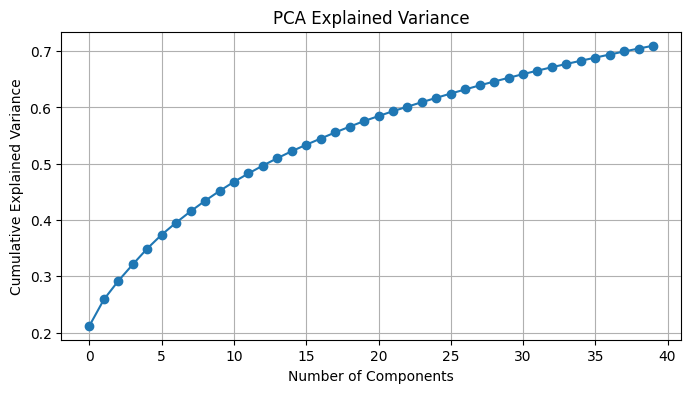

(23925, 60)
(220, 87, 60)
(55, 87, 60)
0      0
1      0
2      0
3      0
4      0
      ..
270    0
271    0
272    1
273    0
274    0
Name: PTSD_Label, Length: 275, dtype: int64


In [ ]:
X_all = pd.read_csv('/content/drive/My Drive/All_features.csv', usecols = extracted_features)

# Performing PCA for SBERT embeddings - retaining 70% variance components
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=40)  # or 50, depending on desired reduction
X_embed_scaled = StandardScaler().fit_transform(X_all.iloc[:,-384:])

X_reduced = pca.fit_transform(X_embed_scaled)

# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)
print(cumulative_variance)

# Plot cumulative variance
plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Replacing SBERT embeddings with PCs
# Step 1: Drop the last 384 columns
X_all = X_all.iloc[:, :-384]

# Step 2: Convert X_reduced (NumPy array) to DataFrame
X_reduced_df = pd.DataFrame(X_reduced, index=X_all.index)

# Optional: rename columns
X_reduced_df.columns = [f'embed_{i}' for i in range(X_reduced_df.shape[1])]

# Step 3: Concatenate
X_all = pd.concat([X_all, X_reduced_df], axis=1)

y_all = y
print(X_all.shape)
X_all = np.array(X_all)
X_all = X_all.reshape(275, 87, -1)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y
)
MAX_CHUNKS = 87
print(X_train.shape)
print(X_test.shape)
print(y_all)

# y_all = y_all_labels.values

In [ ]:
sub_all = pd.read_csv('/content/drive/My Drive/All_features.csv')["participant_id"]
sub_all = sub_all.drop_duplicates().reset_index(drop=True)
sub_all.head()

def remove_padding(X):
    sequences = []
    for x in X:
        # Find non-zero time steps (axis=1 because time is axis 0 in x)
        non_zero_mask = np.any(x[:,:10] != 0, axis=1)
        trimmed = x[non_zero_mask]
        sequences.append(trimmed)
    return sequences

X_no_pad = remove_padding(X_all)

print(X_no_pad[10][:,0])

[0.7781513 0.69897   0.7781513 0.7781513 0.7781513 0.7781513 0.7781513
 0.7781513 0.7781513 0.69897   0.69897   0.60206   0.7781513 0.90309
 0.90309   0.845098  0.9542425 0.9542425 0.90309   0.845098  0.845098
 0.7781513]


In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


def smooth_gradient_resample(mask_array, target_len):
    mask_array = np.array(mask_array)
    n = len(mask_array)

    # 1. Compute smoothed first differences
    diffs = np.abs(np.gradient(mask_array))  # better than np.diff
    diffs = np.convolve(diffs, np.ones(3)/3, mode='same')  # smooth diffs

    # 2. Create cumulative importance (change score)
    weights = diffs + 1e-6
    cum_weights = np.cumsum(weights)
    cum_weights /= cum_weights[-1]  # Normalize to [0, 1]

    # 3. Interpolate based on cumulative importance
    target_positions = np.linspace(0, 1, target_len)
    resampled = np.interp(target_positions, cum_weights, mask_array)

    return resampled

mask_all = []
senti_all = []
for i in range(len(sub_all)):
  sub = sub_all[i]
  print(sub)
  # 1. Load transcript CSV
  df = pd.read_csv("/content/drive/My Drive/MS thesis/all_speakers/"+str(sub)+"_transcript.csv")  # Replace with your filename

  # 2. Split the 'Timestamp' column into start and end seconds
  def parse_timestamp_range(ts_str):
      try:
          start_str, end_str = ts_str.split("–")  # en dash
          return float(start_str), float(end_str)
      except:
          return np.nan, np.nan  # or handle differently

  df[["start", "end"]] = df["Timestamp"].apply(lambda x: pd.Series(parse_timestamp_range(x)))

  # 3. Drop rows with bad timestamps
  df = df.dropna(subset=["start", "end", "Transcript"])

  # 4. Load sentiment analysis pipeline
  sentiment_model = pipeline(
      "sentiment-analysis",
      model="distilbert-base-uncased-finetuned-sst-2-english"
  )

  # 5. Run sentiment analysis
  results = sentiment_model(df["Transcript"].tolist(), truncation=True)

  # 6. Convert to numeric sentiment score
  def convert_sentiment(result):
      label, score = result["label"], result["score"]
      return score if label == "POSITIVE" else -score

  df["sentiment_score"] = [convert_sentiment(res) for res in results]

  senti_all.append(df["sentiment_score"].mean())

  # 7. Create sliding windows
  window_size = 30.0
  stride = 15.0
  end_time = df["end"].max()

  windows = []
  start_time = 0.0
  while start_time < end_time:
      windows.append((start_time, start_time + window_size))
      start_time += stride

  # 8. Compute average sentiment per window
  mask_array = []
  for win_start, win_end in windows:
      in_window = df[(df["start"] < win_end) & (df["end"] > win_start)]
      if not in_window.empty:
          avg_sentiment = in_window["sentiment_score"].mean()
      else:
          avg_sentiment = 0.0  # Or np.nan
      mask_array.append(avg_sentiment)

  mask_array = np.array(mask_array)

  compressed_mask = smooth_gradient_resample(mask_array, target_len=X_no_pad[i].shape[0])

  compressed_mask = np.abs(compressed_mask)

  # Smooth with Gaussian filter (window size ~ 5 points)
  compressed_mask = gaussian_filter1d(compressed_mask, sigma=1)
  compressed_mask = (compressed_mask-np.min(compressed_mask))/(np.max(compressed_mask)-np.min(compressed_mask))


  compressed_mask = np.pad(compressed_mask, (0, 87 - len(compressed_mask)), mode='constant', constant_values=0)


  # compressed_mask[np.abs(compressed_mask) >= 0.5] = 1
  # compressed_mask[np.abs(compressed_mask) < 0.5] = 0.1
  mask_all.append(compressed_mask)

mask_all = np.array(mask_all)
print(mask_all.shape)

300


Device set to use cpu


KeyboardInterrupt: 

In [ ]:
df["sentiment_score"]

In [ ]:
!pip install sentence_transformers

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

mask_recur_all = []
sim_score_all = []
for i in range(len(sub_all)):
  sub = sub_all[i]
  print(sub)
  # Load data
  df = pd.read_csv("/content/drive/My Drive/MS thesis/all_speakers/"+str(sub)+"_transcript.csv")  # Replace with your filename

  # Duration function
  def timestamp_to_seconds(timestamp_range):
      start, end = timestamp_range.split('–')
      def to_sec(t):
          parts = list(map(float, t.split(':')))
          return parts[0] * 60 + parts[1] if len(parts) == 2 else float(parts[0])
      return to_sec(end) - to_sec(start)

  df['duration'] = df['Timestamp'].apply(timestamp_to_seconds)

  # Sentence embeddings
  model = SentenceTransformer("all-MiniLM-L6-v2")
  embeddings = model.encode(df['Transcript'].tolist(), normalize_embeddings=True)

  # Cosine similarity matrix
  similarity_matrix = cosine_similarity(embeddings)
  similarity_matrix = np.clip(similarity_matrix, 0, 1)
  # similarity_matrix[similarity_matrix < 0.5] = 0
  np.fill_diagonal(similarity_matrix, 0)  # remove self-similarity

  upper = upper = np.triu(similarity_matrix, k=1)  # k=1 excludes the diagonal

    # Extract values
  upper_values = upper[upper != 0]

  # Compute the mean
  sim_score = upper_values.mean()

  mask = similarity_matrix.sum(axis=1)  # shape: (T,)

  mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)

  mask_filt = smooth_gradient_resample(mask, target_len=X_no_pad[i].shape[0])

  mask_filt = gaussian_filter1d(mask_filt, sigma=1)

  mask_filt = np.pad(mask_filt, (0, 87 - len(mask_filt)), mode='constant', constant_values=0)

  mask_recur_all.append(mask_filt)
  sim_score_all.append(sim_score)

mask_recur_all = np.array(mask_recur_all)
print(mask_recur_all.shape)


In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

mask_filt = smooth_gradient_resample(mask, target_len=67)

mask_filt = gaussian_filter1d(mask_filt, sigma=1)
# mask_filt = (mask_filt-np.min(mask_filt))/(np.max(mask_filt)-np.min(mask_filt))


plt.plot(mask_filt)
plt.show()

In [ ]:
# np.save('/content/drive/My Drive/mask_recur_all.npy', mask_recur_all)
# np.save('/content/drive/My Drive/mask_all.npy', mask_all)

mask_recur_all = np.load('/content/drive/My Drive/mask_recur_all.npy')
print(mask_recur_all.shape)
mask_all = np.load('/content/drive/My Drive/mask_all.npy')
mask_all = mask_all[:,:,0]
print(mask_all.shape)

(275, 87)
(275, 87)


In [ ]:
# Expand to (275, 87, 1), then repeat along axis=2
# mask_recur_all[:,:5] = mask_recur_all[:,:5]+0.0001
mask_all_rep = np.repeat(mask_recur_all[:, :, np.newaxis], X_all.shape[-1], axis=2)

# mask_all[:,:5] = mask_all[:,:5]+0.0001
mask_all = np.repeat(mask_all[:, :, np.newaxis], X_all.shape[-1], axis=2)

X_all_recur = X_all*mask_all_rep
X_all_senti = X_all*mask_all

X_all = np.concatenate((X_all, X_all_recur, X_all_senti), axis=2)
print(X_all.shape)

# Find rows in X_all that contain NaN
nan_mask = ~np.isnan(X_all).any(axis=(1,2))

# Filter out rows with NaN from both X_all and y_all
X_all = X_all[nan_mask]
y_all = y_all[nan_mask].reset_index(drop=True)
print(X_all.shape)

(275, 87, 180)
(273, 87, 180)


In [ ]:
print(X_all[20,:,0])

In [ ]:
# X_all = np.concatenate((X_all, X_all, X_all), axis=2)

# # Find rows in X_all that contain NaN
# nan_mask = ~np.isnan(X_all).any(axis=(1,2))

# # Filter out rows with NaN from both X_all and y_all
# X_all = X_all[nan_mask]
# y_all = y_all[nan_mask].reset_index(drop=True)
# print(X_all.shape)

In [ ]:
# X_all_baseline = np.mean(X_all[:,:10,:],1)
# for i in range(X_all.shape[1]):
#   X_all[:,i,:] = X_all[:,i,:] - X_all_baseline
#   print(X_all.shape)
# X_all = X_all[:,10:,:]
# X_all = X_all[:,:-10,:]
# print(X_all.shape)

In [ ]:
# Load your label CSV
df = pd.read_csv('/content/drive/My Drive/GroundTruth Table.csv')

# Define labels
labels = ['PTSD_Label',	'Depression_Label',	'Appetite_Label',	'Agency_Label',	'Anxiety_Label',	'Sleep_Label']

y = df[labels[1]]

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Convert sim_score_all to NumPy array if needed
scores = np.array(sim_score_all)

# Group scores by label
group_A = scores[y == 0]
group_B = scores[y == 1]

# Run t-test
t_stat, p_val = ttest_ind(group_A, group_B, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")




Training Fold 1
Class weights: {0: np.float64(0.7315436241610739), 1: np.float64(1.5797101449275361)}
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - accuracy: 0.5075 - loss: 0.7648 - val_accuracy: 0.5818 - val_loss: 0.6548 - learning_rate: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5966 - loss: 0.6811 - val_accuracy: 0.6000 - val_loss: 0.6308 - learning_rate: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6819 - loss: 0.6338 - val_accuracy: 0.6727 - val_loss: 0.6119 - learning_rate: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6775 

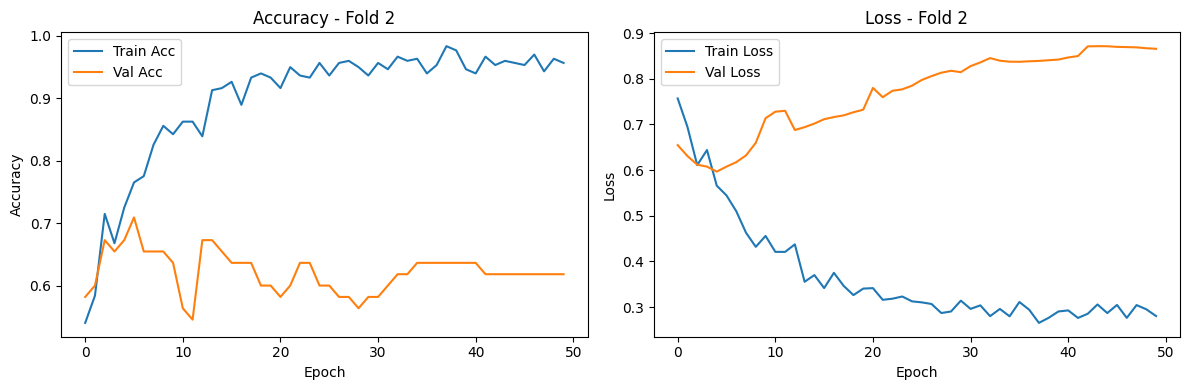


Training Fold 2
Class weights: {0: np.float64(0.7315436241610739), 1: np.float64(1.5797101449275361)}
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.4857 - loss: 0.7591 - val_accuracy: 0.5273 - val_loss: 0.7058 - learning_rate: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5993 - loss: 0.6554 - val_accuracy: 0.6545 - val_loss: 0.6652 - learning_rate: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7188 - loss: 0.5985 - val_accuracy: 0.6182 - val_loss: 0.6576 - learning_rate: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7540 -

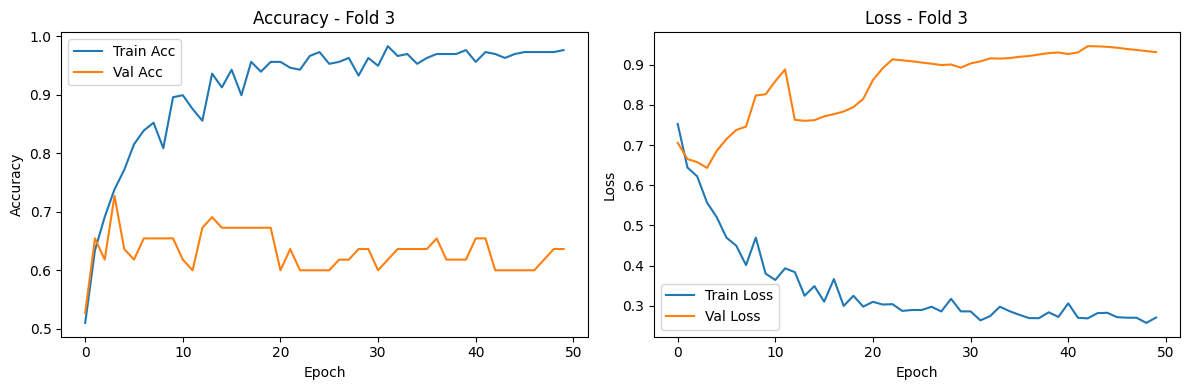


Training Fold 3
Class weights: {0: np.float64(0.7266666666666667), 1: np.float64(1.6029411764705883)}
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.5433 - loss: 0.7507 - val_accuracy: 0.5636 - val_loss: 0.6746 - learning_rate: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6133 - loss: 0.6476 - val_accuracy: 0.6545 - val_loss: 0.6621 - learning_rate: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7100 - loss: 0.6067 - val_accuracy: 0.6182 - val_loss: 0.6984 - learning_rate: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7478 -

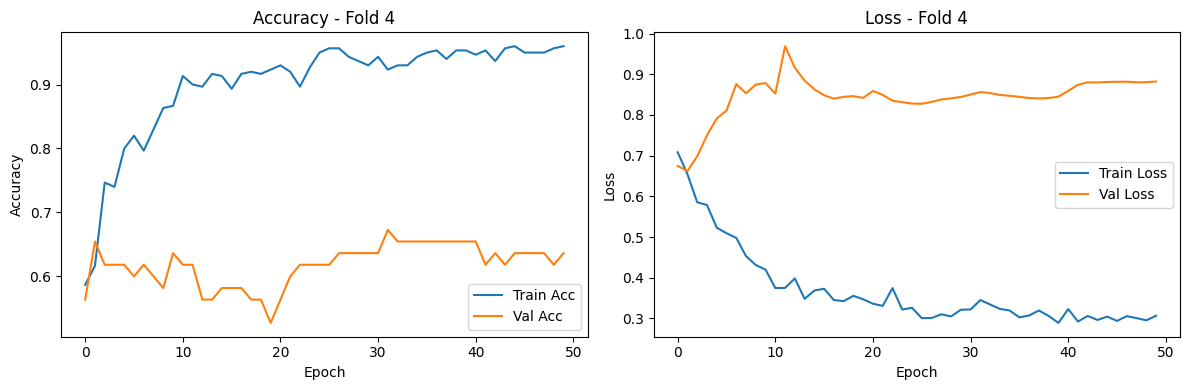


Training Fold 4
Class weights: {0: np.float64(0.73), 1: np.float64(1.5869565217391304)}
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.4860 - loss: 0.7901 - val_accuracy: 0.6852 - val_loss: 0.6127 - learning_rate: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5256 - loss: 0.7298 - val_accuracy: 0.7222 - val_loss: 0.5945 - learning_rate: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5842 - loss: 0.6920 - val_accuracy: 0.7593 - val_loss: 0.5727 - learning_rate: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6082 - loss: 0.6583 

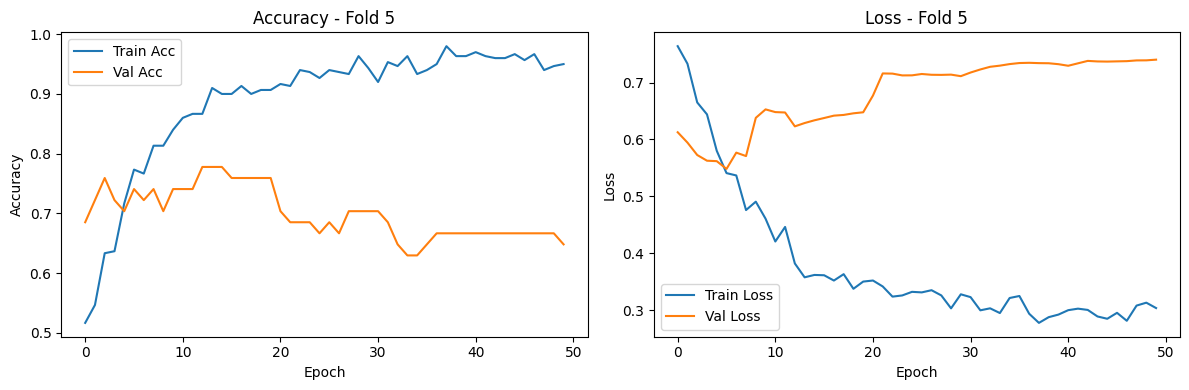


Training Fold 5
Class weights: {0: np.float64(0.73), 1: np.float64(1.5869565217391304)}
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.5462 - loss: 0.7182 - val_accuracy: 0.7222 - val_loss: 0.6434 - learning_rate: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6460 - loss: 0.6492 - val_accuracy: 0.7222 - val_loss: 0.6291 - learning_rate: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7176 - loss: 0.5973 - val_accuracy: 0.7593 - val_loss: 0.6401 - learning_rate: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7019 - loss: 0.5747 

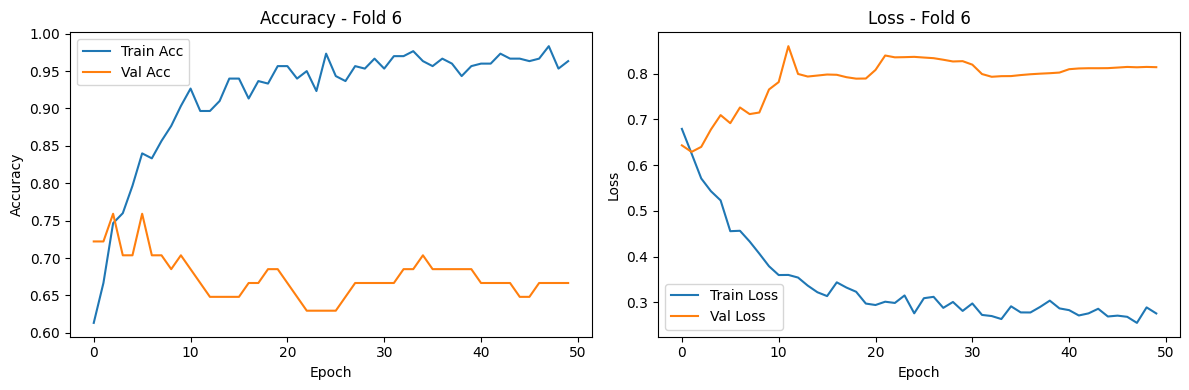


Average Accuracy over 5 folds: 0.6411

Average Sensitivity over 5 folds: 0.4078

Average Specificity over 5 folds: 0.7489


In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Flatten, Bidirectional, GRU, LSTM, GlobalMaxPooling1D, Dense, SimpleRNN, Concatenate, Lambda, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
from imblearn.over_sampling import RandomOverSampler, SMOTE
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample

def smooth_gradient_resample(arr, target_len):
    arr = np.array(arr)
    n = len(arr)

    # 1. Compute smoothed first differences
    diffs = np.abs(np.gradient(arr))  # better than np.diff
    diffs = np.convolve(diffs, np.ones(3)/3, mode='same')  # smooth diffs

    # 2. Create cumulative importance (change score)
    weights = diffs + 1e-6
    cum_weights = np.cumsum(weights)
    cum_weights /= cum_weights[-1]  # Normalize to [0, 1]

    # 3. Interpolate based on cumulative importance
    target_positions = np.linspace(0, 1, target_len)
    # print(target_positions.shape)
    # print(cum_weights.shape)
    # print(arr.shape)

    resampled = np.interp(target_positions, cum_weights, arr)

    return resampled

# Wrap your model in a function
# def build_model(input_shape):
#     model = Sequential([
#         Input(shape=input_shape),
#         Conv1D(16, kernel_size=3, activation='relu'),#, padding='same'),
#         BatchNormalization(),
#         Dropout(0.3),
#         # Bidirectional(LSTM(16, return_sequences=True)),

#         SimpleRNN(8, return_sequences=True),

#         GlobalMaxPooling1D(),
#         Dense(4, activation='relu'),
#         Dropout(0.3),
#         # Dense(16, activation='relu'),
#         Dense(2, activation='softmax')  # Binary cōlassification
#     ])
#     model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# Learningrate scheduler
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy

loss = CategoricalCrossentropy(label_smoothing=0.1)


def scheduler(epoch, lr):
  if epoch<=10:#30
    return lr
  else:
    if epoch%10==0:
        return lr*5
    elif epoch%10==3:
        return lr * 0.1
    else:
        return lr
  # return lr

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

def build_model_ragged(input_dim):
    inp = Input(shape=(None, input_dim))  # variable-length support

    # Slice into 9 segments: 0-1,1-2,2-3 for default, 3-4,4-5,5-6 for sentiment and 6-7,7-8,8-9 for recurrence

    grp = 0
    # Calculate the size of each segment
    size1 = len(top_features_list_before)
    size2 = len(top_features_list_after)
    size3 = input_dim // 3 - size1 - size2

    x1 = Lambda(lambda x: x[:, :, int(X_all.shape[2]/3)*grp:int(X_all.shape[2]/3)*grp + len(top_features_list_before)], output_shape=(None, size1))(inp)     # First 20 features
    x2 = Lambda(lambda x: x[:, :, int(X_all.shape[2]/3)*grp + len(top_features_list_before):int(X_all.shape[2]/3)*grp + len(top_features_list_before)+len(top_features_list_after)], output_shape=(None, size2))(inp)   # Next 20
    x3 = Lambda(lambda x: x[:, :, int(X_all.shape[2]/3)*grp + len(top_features_list_before)+len(top_features_list_after):(X_all.shape[2]/3)*(grp+1)], output_shape=(None, size3))(inp)     # Last 10

    grp = 1
    x4 = Lambda(lambda x: x[:, :, int(X_all.shape[2]/3)*grp:int(X_all.shape[2]/3)*grp + len(top_features_list_before)], output_shape=(None, size1))(inp)     # First 20 features
    x5 = Lambda(lambda x: x[:, :, int(X_all.shape[2]/3)*grp + len(top_features_list_before):int(X_all.shape[2]/3)*grp + len(top_features_list_before)+len(top_features_list_after)], output_shape=(None, size2))(inp)   # Next 20
    x6 = Lambda(lambda x: x[:, :, int(X_all.shape[2]/3)*grp + len(top_features_list_before)+len(top_features_list_after):(X_all.shape[2]/3)*(grp+1)], output_shape=(None, size3))(inp)     # Last 10

    grp = 2
    x7 = Lambda(lambda x: x[:, :, int(X_all.shape[2]/3)*grp:int(X_all.shape[2]/3)*grp + len(top_features_list_before)], output_shape=(None, size1))(inp)     # First 20 features
    x8 = Lambda(lambda x: x[:, :, int(X_all.shape[2]/3)*grp + len(top_features_list_before):int(X_all.shape[2]/3)*grp + len(top_features_list_before)+len(top_features_list_after)], output_shape=(None, size2))(inp)   # Next 20
    x9 = Lambda(lambda x: x[:, :, int(X_all.shape[2]/3)*grp + len(top_features_list_before)+len(top_features_list_after):(X_all.shape[2]/3)*(grp+1)], output_shape=(None, size3))(inp)     # Last 10

    # Apply Conv1D to each segment
    x1 = Conv1D(4, kernel_size=5, strides=2, activation='relu')(x1)
    x1 = MaxPooling1D(pool_size=2,strides=2)(x1)
    x2 = Conv1D(4, kernel_size=5, strides=2, activation='relu')(x2)
    x2 = MaxPooling1D(pool_size=2,strides=2)(x2)
    x3 = Conv1D(4, kernel_size=5, strides=2, activation='relu')(x3)
    x3 = MaxPooling1D(pool_size=2,strides=2)(x3)
    x4 = Conv1D(4, kernel_size=5, strides=2, activation='relu')(x4)
    x4 = MaxPooling1D(pool_size=2,strides=2)(x4)
    x5 = Conv1D(4, kernel_size=5, strides=2, activation='relu')(x5)
    x5 = MaxPooling1D(pool_size=2,strides=2)(x5)
    x6 = Conv1D(4, kernel_size=5, strides=2, activation='relu')(x6)
    x6 = MaxPooling1D(pool_size=2,strides=2)(x6)
    x7 = Conv1D(4, kernel_size=5, strides=2, activation='relu')(x7)
    x7 = MaxPooling1D(pool_size=2,strides=2)(x7)
    x8 = Conv1D(4, kernel_size=5, strides=2, activation='relu')(x8)
    x8 = MaxPooling1D(pool_size=2,strides=2)(x8)
    x9 = Conv1D(4, kernel_size=5, strides=2, activation='relu')(x9)
    x9 = MaxPooling1D(pool_size=2,strides=2)(x9)

    # Normalize and regularize
    x1 = BatchNormalization()(x1)
    x2 = BatchNormalization()(x2)
    x3 = BatchNormalization()(x3)
    x4 = BatchNormalization()(x4)
    x5 = BatchNormalization()(x5)
    x6 = BatchNormalization()(x6)
    x7 = BatchNormalization()(x7)
    x8 = BatchNormalization()(x8)
    x9 = BatchNormalization()(x9)

    x1 = Dropout(0.5)(x1)
    x2 = Dropout(0.5)(x2)
    x3 = Dropout(0.5)(x3)
    x4 = Dropout(0.5)(x4)
    x5 = Dropout(0.5)(x5)
    x6 = Dropout(0.5)(x6)
    x7 = Dropout(0.5)(x7)
    x8 = Dropout(0.5)(x8)
    x9 = Dropout(0.5)(x9)

    # Concatenate processed segments
    xmod1 = Concatenate(axis=-1)([x1,x4,x7])
    xmod2 = Concatenate(axis=-1)([x2,x5,x8])
    xmod3 = Concatenate(axis=-1)([x3,x6,x9])

    # Conv1D again
    xmod1 = Conv1D(8, kernel_size=5, strides=2, activation='relu')(xmod1)
    xmod1 = MaxPooling1D(pool_size=2,strides=2)(xmod1)
    xmod2 = Conv1D(8, kernel_size=5, strides=2, activation='relu')(xmod2)
    xmod2 = MaxPooling1D(pool_size=2,strides=2)(xmod2)
    xmod3 = Conv1D(8, kernel_size=5, strides=2, activation='relu')(xmod3)
    xmod3 = MaxPooling1D(pool_size=2,strides=2)(xmod3)

    # Normalize and regularize
    xmod1 = BatchNormalization()(xmod1)
    xmod2 = BatchNormalization()(xmod2)
    xmod3 = BatchNormalization()(xmod3)

    xmod1 = Dropout(0.5)(xmod1)
    xmod2 = Dropout(0.5)(xmod2)
    xmod3 = Dropout(0.5)(xmod3)

    # Concatenate processed segments
    x = Concatenate(axis=-1)([xmod1, xmod2, xmod3])

    x = Conv1D(8, kernel_size=3, strides=1, activation='relu')(inp)
    x = MaxPooling1D(pool_size=2,strides=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # x = Conv1D(8, kernel_size=3, activation='relu')(inp)
    # x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)

    # x = Conv1D(8, kernel_size=3, strides=1, activation='relu')(inp)
    # x = MaxPooling1D(pool_size=2)(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.5)(x)

    # x = Conv1D(4, kernel_size=3, strides=1, activation='relu')(inp)
    # # x = MaxPooling1D(pool_size=2)(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)

    # x = SimpleRNN(4, return_sequences=True)(x)
    x = Bidirectional(LSTM(16, return_sequences=True))(x)
    x = GlobalMaxPooling1D()(x)

    # x = Dense(4, activation='relu')(x)
    x = Dropout(0.5)(x)

    out = Dense(2, activation='softmax')(x)
    # out = Dense(6, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.005), loss=loss, metrics=['accuracy'])
    return model

def remove_padding(X):
    sequences = []
    for x in X:
        # Find non-zero time steps (axis=1 because time is axis 0 in x)
        non_zero_mask = np.any(x[:,:10] != 0, axis=1)
        trimmed = x[non_zero_mask]
        if len(trimmed)==0:
          trimmed = x[:10]
        sequences.append(trimmed)
    return sequences


def is_all_zeros(timestep):
    return np.all(timestep == 0)

def remove_trailing_zeros(sequence):
    # sequence shape: (T, F)
    for i in reversed(range(sequence.shape[0])):
        if not is_all_zeros(sequence[i]):
            return sequence[:i+1]
    return sequence[:1]  # fallback: keep at least one timestep

def process_sequences(X_train, y_train, min_len=10, max_len=60, pad_len=87):
    num_sequences = X_train.shape[0]
    num_features = X_train.shape[2]

    X_out = []
    y_out = []

    for i in range(num_sequences):
        seq = X_train[i]
        label = np.array(y_train.iloc[i])

        X_out.append(seq)
        y_out.append(label)

    for t in range(10):
      for i in range(num_sequences):
          seq = X_train[i]
          label = np.array(y_train.iloc[i])

          # Step 1: remove trailing zero-padding
          unpadded_seq = remove_trailing_zeros(seq)
          T = unpadded_seq.shape[0]

          # Ensure enough length for sampling
          if T < min_len:
              continue  # Skip sequences that are too short after trimming

          sub_len = np.random.randint(min_len, min(max_len + 1, T + 1))
          start_idx = np.random.randint(0, T - sub_len + 1)

          sub_seq = unpadded_seq[start_idx:start_idx + sub_len]

          # Step 3: zero-pad to pad_len
          padded_seq = np.zeros((pad_len, num_features))
          padded_seq[:sub_len] = sub_seq

          X_out.append(padded_seq)
          y_out.append(label)

    return np.array(X_out), np.array(y_out)

def generate_test_subsamples(X_test, y_test, n_samples=30, min_len=30, max_len=50, pad_len=30):
    num_features = X_test.shape[2]
    all_subsamples = []
    all_indices = []

    for i in range(X_test.shape[0]):
        seq = remove_trailing_zeros(X_test[i])
        T = seq.shape[0]

        if T < min_len:
            continue  # skip too-short sequences

        for _ in range(n_samples):
            sub_len = np.random.randint(min_len, min(max_len + 1, T + 1))
            start_idx = np.random.randint(0, T - sub_len + 1)
            sub_seq = seq[start_idx:start_idx + sub_len]

            # Pad
            padded_seq = np.zeros((sub_len, num_features))
            # padded_seq = np.zeros((pad_len, num_features))
            padded_seq[:sub_len] = sub_seq

            all_subsamples.append(padded_seq)
            all_indices.append(i)

    return np.array(all_subsamples), np.array(all_indices)


# K-fold Cross Validation for 10 iterations
all_accuracies = []
all_sensitivities = []
all_specificities = []
all_cm = []

for it in range(1):
  kf = StratifiedKFold(n_splits=5, shuffle=True)
  # kf = KFold(n_splits=5, shuffle=True)

  fold = 1
  for train_index, test_index in kf.split(X_all, y_all):
      print(f"\nTraining Fold {fold}")
      X_train, X_test = X_all[train_index], X_all[test_index]
      y_train, y_test = y_all[train_index], y_all[test_index]

      y_train = pd.get_dummies(y_train)
      y_test = pd.get_dummies(y_test)

      from sklearn.utils.class_weight import compute_class_weight

      # X_train, y_train = process_sequences(X_train, y_train)
      # X_test, y_test = process_sequences(X_test, y_test)


      # Make sure y_train is a 1D array of class labels
      y_train_labels = np.argmax(y_train, axis=1) if y_train.ndim == 2 else y_train

      class_weights = compute_class_weight(
          class_weight='balanced',
          classes=np.unique(y_train_labels),
          y=y_train_labels
      )

      # Convert to dict for Keras
      class_weight_dict = dict(enumerate(class_weights))

      print("Class weights:", class_weight_dict)

      # Step 1: Flatten X_train from (220, 87, 40) to (220, 87*40)
      X_flat = X_train.reshape((X_train.shape[0], -1))  # shape becomes (220, 3480)

      # Step 2: Convert y_train from one-hot to class labels
      y_labels = np.argmax(y_train, axis=1)  # shape becomes (220,)

      # Step 3: Apply RandomOverSampler
      ros = SMOTE()#RandomOverSampler()
      X_resampled, y_resampled = ros.fit_resample(X_flat, y_labels)

      # Step 4: Reshape X back to time series shape
      X_train = X_resampled.reshape((-1, X_all.shape[1], X_train.shape[2]))

      # Step 5: Convert y_resampled back to one-hot if needed
      y_train = to_categorical(y_resampled)


      # Remove zero padding
      X_train = remove_padding(X_train)
      X_test = remove_padding(X_test)

      for iii in range(len(X_train)):
        x_tmp = []
        for fff in range(X_train[iii].shape[1]):
          x_tmp.append(smooth_gradient_resample(X_train[iii][:,fff], 50))
        X_train[iii] = np.array(x_tmp).T

      for iii in range(len(X_test)):
        x_tmp = []
        for fff in range(X_test[iii].shape[1]):
          x_tmp.append(smooth_gradient_resample(X_test[iii][:,fff], 50))
        X_test[iii] = np.array(x_tmp).T

      # 2. Flatten all valid time steps to fit scaler
      all_train = np.vstack(X_train)  # Shape: (total_time_steps, features)

      # 3. Fit scaler
      scaler = StandardScaler()
      scaler.fit(all_train)

      # 4. Transform each sequence individually
      X_train = [scaler.transform(x) for x in X_train]
      X_test = [scaler.transform(x) for x in X_test]


      # Convert to ragged tensors so that model can handle inputs of variable temporal length
      X_train = tf.ragged.constant(X_train, dtype=tf.float32)
      X_test = tf.ragged.constant(X_test, dtype=tf.float32)

      X_train = X_train.to_tensor()
      X_test = X_test.to_tensor()

      # Make sure y_train is a 1D array of class labels
      y_train_labels = np.argmax(y_train, axis=1) if y_train.ndim == 2 else y_train

      class_weights = compute_class_weight(
          class_weight='balanced',
          classes=np.unique(y_train_labels),
          y=y_train_labels
      )

      # Convert to dict for Keras
      class_weight_dict = dict(enumerate(class_weights))

      print("Class weights:", class_weight_dict)

      # model = build_model(input_shape=(MAX_CHUNKS, X_all.shape[2]))
      model = build_model_ragged(input_dim=X_train.shape[2])
      # model.summary()
      history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[lr_scheduler], verbose=1, shuffle=True)

      # # Step 1: Create test sub-samples
      # X_test, sample_indices = generate_test_subsamples(X_test, y_test)

      # # Step 2: Predict on all sub-samples
      # probs = model.predict(X_test)  # shape (num_subsamples, num_classes)

      # # Step 3: Aggregate using argmax of confidence
      # from collections import defaultdict

      # # Store max prob and label per original test sample
      # index_to_best = defaultdict(lambda: (0.0, -1))  # maps sample_idx -> (max_confidence, label)

      # for i in range(probs.shape[0]):
      #     idx = sample_indices[i]
      #     prob = probs[i]
      #     pred_class = np.argmax(prob)
      #     confidence = prob[pred_class]

      #     # Keep the most confident prediction
      #     if confidence > index_to_best[idx][0]:
      #         index_to_best[idx] = (confidence, pred_class)

      # # Step 4: Build final predictions
      # unique_indices = sorted(index_to_best.keys())
      # y_pred = np.array([index_to_best[idx][1] for idx in unique_indices])
      # y_true = np.array([np.array(y_test.iloc[idx]) for idx in unique_indices])
      # y_true = np.argmax(y_true,1)

      # Evaluate
      preds = (model.predict(X_test) > 0.5).astype("int32")

      from sklearn.metrics import accuracy_score, confusion_matrix

      # Convert one-hot to class labels
      y_true = np.argmax(y_test, axis=1)
      y_pred = np.argmax(preds, axis=1)

      # Accuracy
      accuracy = accuracy_score(y_true, y_pred)

      # Confusion matrix: [[TN, FP], [FN, TP]]
      cm = confusion_matrix(y_true, y_pred)

      tn, fp, fn, tp = cm.ravel()

      # Sensitivity (Recall for Positive Class)
      sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0.0

      # Specificity (Recall for Negative Class)
      specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0

      print(f"Accuracy: {accuracy:.4f}")
      print(f"Sensitivity (Recall for positive class): {sensitivity:.4f}")
      print(f"Specificity (Recall for negative class): {specificity:.4f}")
      print(cm)


      all_accuracies.append(accuracy)
      all_sensitivities.append(sensitivity)
      all_specificities.append(specificity)
      all_cm.append(cm)

      # Plot for this fold
      plt.figure(figsize=(12, 4))

      # Accuracy plot
      plt.subplot(1, 2, 1)
      plt.plot(history.history['accuracy'], label='Train Acc')
      plt.plot(history.history['val_accuracy'], label='Val Acc')
      plt.title(f'Accuracy - Fold {fold+1}')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()

      # Loss plot
      plt.subplot(1, 2, 2)
      plt.plot(history.history['loss'], label='Train Loss')
      plt.plot(history.history['val_loss'], label='Val Loss')
      plt.title(f'Loss - Fold {fold+1}')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()

      plt.tight_layout()
      plt.show()

      fold += 1

# Average accuracy
print(f"\nAverage Accuracy over 5 folds: {np.mean(all_accuracies):.4f}")
print(f"\nAverage Sensitivity over 5 folds: {np.mean(all_sensitivities):.4f}")
print(f"\nAverage Specificity over 5 folds: {np.mean(all_specificities):.4f}")

In [ ]:
input_dim = X_train.shape
size1 = len(top_features_list_before)
size2 = len(top_features_list_after)
print(size1)

print(size2)
size3 = input_dim // 3 - size1 - size2



print(size3)

In [ ]:
X_train = X_all[train_index]

# Step 1: Flatten X_train from (220, 87, 40) to (220, 87*40)
X_flat = X_train.reshape((X_train.shape[0], -1))  # shape becomes (220, 3480)

# Step 4: Reshape X back to time series shape
X_train = X_resampled.reshape((-1, 67, X_train.shape[2]))

# Remove zero padding
X_train = remove_padding(X_train)

print(X_train[0].shape)
print(X_train[0][:,0])

# 2. Flatten all valid time steps to fit scaler
all_train = np.vstack(X_train)  # Shape: (total_time_steps, features)

# 3. Fit scaler
scaler = StandardScaler()
scaler.fit(all_train)

# 4. Transform each sequence individually
X_train = [scaler.transform(x) for x in X_train]

# Convert to ragged tensors so that model can handle inputs of variable temporal length
X_train = tf.ragged.constant(X_train, dtype=tf.float32)
print(X_train[10,:,:].shape)


X_train = X_train.to_tensor()
print(X_train[10,:,:].shape)


In [ ]:
# from scipy.ndimage import gaussian_filter1d

# # Smooth with Gaussian filter (window size ~ 5 points)
# smoothed = gaussian_filter1d(mask_all[10,:], sigma=1)

# plt.plot(y_train[10,:])
# plt.show()

for i in range(275):
  has_nan = np.isnan(mask_all[i,:]).any()
  print(str(i) + ": "+str(has_nan))

aa = X_train[206,10,:]
print(aa)

In [ ]:
pip install tslearn

In [ ]:
from tslearn.metrics import dtw

n = len(X_all)
dtw_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        dtw_matrix[i, j] = dtw(X_all[i], X_all[j])

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(metric='precomputed',init='random', random_state=42)
embedding = tsne.fit_transform(dtw_matrix)

plt.scatter(embedding[y_all == 0, 0], embedding[y_all == 0, 1], label='Class 0')
plt.scatter(embedding[y_all == 1, 0], embedding[y_all == 1, 1], label='Class 1')
plt.legend()
plt.title("t-SNE with DTW Distance Matrix")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

# --- CONFIG ---
window_size = 20
step_size = 5

# --- Your Data ---
# X_all: list of np.arrays, shape = (timesteps_i, features)
# Y_all: list or array of labels (0 or 1)
X_class0 = [x for x, y in zip(X_all, y_all) if y == 0]
X_class1 = [x for x, y in zip(X_all, y_all) if y == 1]

# --- Normalize ---
scaler = StandardScaler()
all_seqs = X_class0 + X_class1
flattened = np.vstack([s for s in all_seqs])
scaler.fit(flattened)

X_class0 = [scaler.transform(x) for x in X_class0]
X_class1 = [scaler.transform(x) for x in X_class1]

# --- Reference class 0 windows ---
ref_windows = []
for seq in X_class0:
    for i in range(0, len(seq) - window_size + 1, step_size):
        ref_windows.append(seq[i:i+window_size])

# --- Build heatmap matrix ---
heatmap = []
valid_lengths = []

for seq in X_class1:
    distances = []
    for i in range(0, len(seq) - window_size + 1, step_size):
        window = seq[i:i+window_size]
        dists = [euclidean(window.flatten(), ref.flatten()) for ref in ref_windows]
        distances.append(min(dists))
    heatmap.append(distances)
    valid_lengths.append(len(distances))

# Pad shorter sequences with NaN to align columns
max_len = max(valid_lengths)
heatmap_padded = np.full((len(heatmap), max_len), np.nan)

for i, row in enumerate(heatmap):
    heatmap_padded[i, :len(row)] = row

# --- Plot heatmap ---
plt.figure(figsize=(12, 6))
plt.imshow(heatmap_padded, aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Distance to Class 0')
plt.xlabel('Window Index (time)')
plt.ylabel('Class 1 Sequence Index')
plt.title('Heatmap of Class 1 Windows vs. Class 0 (Euclidean Distance)')
plt.tight_layout()
plt.show()


In [ ]:
# Flatten heatmap and remove NaN and 0 values
values = heatmap_padded.flatten()
values = values[~np.isnan(values)]       # Remove NaNs
values = values[values != 0]             # Remove exact 0s
values = values[values < 6*np.std(values)]       # Remove infinities
# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(values, bins=30, color='steelblue', edgecolor='black')
plt.title('Histogram of Heatmap Values (Excluding 0s and NaNs)')
plt.xlabel('Distance to Class 0')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
print(np.sum(y_train,0))
print(y_train.shape)


In [ ]:
aa = np.max(np.max(X_train, axis=0),axis=0)
plt.hist(aa)
plt.show()

In [ ]:
# Average accuracy
print(f"\nAverage Accuracy over 5 folds: {np.mean(all_accuracies):.4f}")
print(f"\nAverage Sensitivity over 5 folds: {np.mean(all_sensitivities):.4f}")
print(f"\nAverage Specificity over 5 folds: {np.mean(all_specificities):.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix


# Convert one-hot to class labels
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(preds, axis=1)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Confusion matrix: [[TN, FP], [FN, TP]]
cm = confusion_matrix(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()

# Sensitivity (Recall for Positive Class)
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0.0

# Specificity (Recall for Negative Class)
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall for positive class): {sensitivity:.4f}")
print(f"Specificity (Recall for negative class): {specificity:.4f}")
print(cm)

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
print(X_train.shape)
print(y_train.shape)

In [ ]:
import numpy as np

# X_train shape: (220, 87, 40)
pad_counts = []

for sample in X_train:
    count = 0
    # Iterate backwards over timesteps
    for timestep in reversed(sample):
        if np.all(timestep == 0):
            count += 1
        else:
            break  # Stop when a non-zero timestep is found
    pad_counts.append(count)

pad_counts = np.array(pad_counts)

print(pad_counts)
plt.hist(pad_counts, bins=range(1, 100))
plt.show()
print(np.mean(pad_counts))

In [ ]:
preds